<a href="https://colab.research.google.com/github/Ahella-Bassem-Mohammed/Stroke_Pre-Detection_Analysis/blob/main/Stroke_Project_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade scikit-learn xgboost

In [ ]:
!pip install xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
pip install imbalanced-learn

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Load the dataset
file_path = "Pre-processed Stroke Data.csv"  # Change to your file path
df = pd.read_csv(file_path)

# Separate features and target
X = df.drop(columns=["stroke"])
y = df["stroke"]

# Apply SMOTE to generate synthetic stroke cases
smote = SMOTE(sampling_strategy=0.25, random_state=42)  # Increase stroke cases to 25%
X_resampled, y_resampled = smote.fit_resample(X, y)

# Apply Undersampling to reduce excess no-stroke cases
undersampler = RandomUnderSampler(sampling_strategy=0.6, random_state=42)  # Keep 60% no-stroke cases
X_final, y_final = undersampler.fit_resample(X_resampled, y_resampled)

# Convert back to DataFrame
balanced_df = pd.DataFrame(X_final, columns=X.columns)
balanced_df["stroke"] = y_final

# Save the balanced dataset
balanced_df.to_csv("Balanced_Stroke_Data.csv", index=False)

# Check new class distribution
print(balanced_df["stroke"].value_counts(normalize=True) * 100)


FileNotFoundError: [Errno 2] No such file or directory: 'Pre-processed Stroke Data.csv'

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}


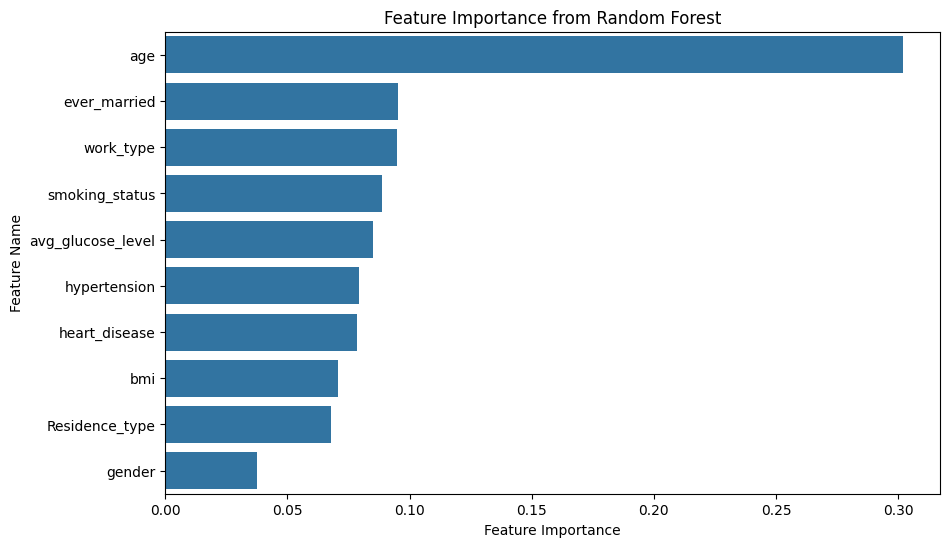


===== Model Evaluation =====
Stacking Model Accuracy: 0.8765432098765432
Stacking Model F1-Score: 0.8467432950191571
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       405
         1.0       0.79      0.91      0.85       243

    accuracy                           0.88       648
   macro avg       0.87      0.88      0.87       648
weighted avg       0.88      0.88      0.88       648


✅ Model and Scaler Saved Successfully!


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_curve

# ===========================
# Step 1: Load and Prepare Data
# ===========================
df = pd.read_csv("/content/Balanced_Stroke_Data.csv")
data = pd.DataFrame(df)

# Separate features (X) and target (y)
X = data.drop("stroke", axis=1)
y = data["stroke"]

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ===========================
# Step 2: Handle Imbalanced Data Using SMOTE
# ===========================
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ===========================
# Step 3: Scale the Data
# ===========================
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# ===========================
# Step 4: Hyperparameter Tuning for Random Forest
# ===========================
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

rf_random = RandomizedSearchCV(
    estimator=rf, param_distributions=param_grid,
    n_iter=20, scoring='f1', cv=5, verbose=2, random_state=42, n_jobs=-1
)

rf_random.fit(X_train_resampled, y_train_resampled)

# Select best model
best_rf = rf_random.best_estimator_
print("Best Parameters:", rf_random.best_params_)

# ===========================
# Step 5: Feature Selection Using Feature Importance
# ===========================
feature_importances = best_rf.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_idx], y=[feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance from Random Forest")
plt.show()

# Keep only important features
important_features = [feature_names[i] for i in sorted_idx if feature_importances[i] > 0.01]
X_train_selected = X_train_resampled[:, sorted_idx[:len(important_features)]]
X_test_selected = X_test_scaled[:, sorted_idx[:len(important_features)]]

# ===========================
# Step 6: Train an Ensemble Model (Stacking Classifier)
# ===========================
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=7, class_weight="balanced", random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, class_weight="balanced", random_state=42))
]

meta_model = GaussianNB()

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_model.fit(X_train_selected, y_train_resampled)

# Make probability predictions
y_scores = stacking_model.predict_proba(X_test_selected)[:, 1]

# Determine the best threshold using Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
optimal_idx = np.argmax(2 * (precision * recall) / (precision + recall))  # Maximizing F1-score
optimal_threshold = thresholds[optimal_idx]

# Make final predictions based on the best threshold
y_pred_stacking = (y_scores >= optimal_threshold).astype(int)

# Evaluate model
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)

print("\n===== Model Evaluation =====")
print("Stacking Model Accuracy:", accuracy_stacking)
print("Stacking Model F1-Score:", f1_stacking)
print("Classification Report:\n", classification_report(y_test, y_pred_stacking))

# ===========================
# Step 7: Save the Best Model and Scaler
# ===========================
# joblib.dump(stacking_model, "best_stroke_model.pkl")
# joblib.dump(scaler, "scaler.pkl")

print("\n✅ Model and Scaler Saved Successfully!")



In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np


data = pd.read_csv("/content/Balanced_Stroke_Data.csv")


X = data.drop("stroke", axis=1)
y = data["stroke"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


model = RandomForestClassifier(n_estimators=200, max_depth=7, class_weight="balanced", random_state=42)


skf = StratifiedKFold(n_splits=5 , shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=skf, scoring='f1')


print("===== التحقق المتقاطع =====")
print(f"Cross-validation F1-score: {np.mean(cross_val_scores):.4f}")

model.fit(X_train_resampled, y_train_resampled)

# التقييم النهائي على مجموعة الاختبار
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# --- طباعة النتائج النهائية ---
print("\n===== التقييم النهائي على مجموعة الاختبار =====")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
